 # Yelp Reviews - Stars Prediction Via LSTM

In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
# load data
data = pd.read_csv('data/yelp.csv')

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(data.text, 
                                                    data.stars, 
                                                    test_size = .2,
                                                    stratify = data.stars,
                                                    shuffle = True,
                                                    random_state = 42)

# fit tokenizer on training data
tokenizer = Tokenizer(num_words = 10000, oov_token='<unk>')
tokenizer.fit_on_texts(X_train)

# prepare sequences to be used by model
X_tr = tokenizer.texts_to_sequences(X_train)
X_te = tokenizer.texts_to_sequences(X_test)

Xtr32 = pad_sequences(X_tr, maxlen = 32)
Xte32 = pad_sequences(X_te, maxlen = 32)

# transform output
ytr = pd.get_dummies(y_train).to_numpy()
yte = pd.get_dummies(y_test).to_numpy()

In [18]:
# LSTM model
config = {
    'embed_size': 100,
    'layer_size': 32,
    'output_size': ytr.shape[1],
    'dropout': .5,
    'epochs': 100,
    'batch_size': 32,
}

model = keras.Sequential([
  layers.Embedding(tokenizer.num_words, config['embed_size']),
  layers.LSTM(config['layer_size']),
  layers.Dropout(config['dropout']),
  layers.Dense(32, activation = 'relu'),
  layers.Dropout(.25),
  layers.Dense(config['output_size'], activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,018,245
Trainable params: 1,018,245
No

In [19]:
model.compile(optimizer= 'SGD',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [20]:
### Due to the error from callbacks=[PlotLossesKeras()], I used an alternative code snippet brought in from outside
### https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e#file-live_loss_plot_keras-ipynb
### Live loss plots in Jupyter Notebook for Keras
### by Piotr Migdał

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

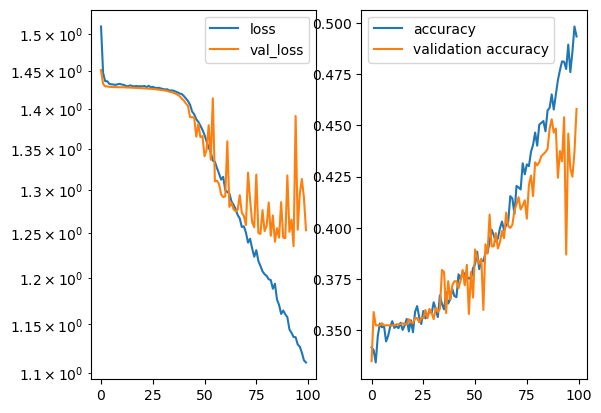

250/250 [==============================] - 2s 9ms/step - loss: 1.1108 - acc: 0.4934 - val_loss: 1.2535 - val_acc: 0.4580


In [21]:
# For Question 2
#from livelossplot import PlotLossesKeras

history = model.fit(Xtr32, ytr,
    batch_size = config['batch_size'],
    epochs=config['epochs'],
    validation_data=(Xte32, yte),
    callbacks=[plot])

* Loss plot shows that the loss computed on both train and validation(test in this case) sets decrease over epochs but the loss on the validation set starts departing from the loss on trainset at the 70th epoch approximately and its trend becomes flattened in contrast with the loss on trainset which keeps decreasing. Likewise, the accuracy computed on the validation set also starts departing from the accuracy on the train set at that point of epochs. It represents that the model begins overfitting on the train dataset from the 70th epoch approximately, which results in the bad performance on the validation set. 

In [11]:
def array_to_list(y_pred):
    return [np.argmax(y_pred[i,])+1 for i in range(y_pred.shape[0])]

In [14]:
@tf.autograph.experimental.do_not_convert
def output(x):
    return model.predict(x)

# For Question 2
y_pred = array_to_list(output(Xte32))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f'Accuracy: {np.trace(cm)}/{np.sum(cm)} = {100*np.trace(cm)/np.sum(cm)}')

              precision    recall  f1-score   support

           1       0.46      0.31      0.37       150
           2       0.32      0.29      0.31       185
           3       0.29      0.38      0.33       292
           4       0.45      0.67      0.54       705
           5       0.66      0.31      0.42       668

    accuracy                           0.44      2000
   macro avg       0.44      0.39      0.39      2000
weighted avg       0.49      0.44      0.44      2000

[[ 46  41  28  27   8]
 [ 18  54  65  43   5]
 [ 11  30 110 133   8]
 [ 13  28 110 470  84]
 [ 13  14  67 366 208]]
Accuracy: 888/2000 = 44.4




- when looking at "support" which shows the actual occurences of each label, we can see the testset is imbalanced in that the number of instances corresponding to the class 4 and 5 is much bigger than the other three labels. 

- according to "precision", the model shows the best performance in the ability not to label an instance positive that is actually negative, when the label 5 is considered postive.

- according to "recall", the classifier's ability to find all positive instances becomes the most notable, when the label 4 is considered positive. 

- according to "f1" which is the weighted average of Precision and Recall, the model's performance is the best, when the label 4 is thought of as positive.

- the overall accuracy of the model is 0.44

- precision is the highest metric among the three metrics based on both macro and weighted average.